# Feature Dependence

### Import libraries and set plotting style

In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import statsmodels.api as sm
from matplotlib.patches import Patch

sys.path.append('../scr')
from data_preprocessing import *
from analysis import *
from utils import *
from plot import *

 ### Feature Numbers and Model Types

In [5]:
feature_numbers = ['9','20']  
confidence = ['11']
model_types = ['LP','RP']  

### Load CSV files

In [6]:
df_predictions = load_and_clean_predictions('credit','predictions',feature_numbers, model_types, data_path='../predictions/')

Loaded file: ../predictions/credit_predictions_9LP_1204_2151.csv for model 9LP
Loaded file: ../predictions/credit_predictions_9RP_1204_2202.csv for model 9RP
Loaded file: ../predictions/credit_predictions_20LP_1104_2235.csv for model 20LP
Loaded file: ../predictions/credit_predictions_20RP_1104_2259.csv for model 20RP


In [7]:
df_confidence = load_and_clean_predictions('credit','average_confidence',confidence, model_types, data_path='../predictions/')

Loaded file: ../predictions/credit_average_confidence_11LP_1204_2238.csv for model 11LP
Loaded file: ../predictions/credit_average_confidence_11RP_1204_2120.csv for model 11RP


In [8]:
# df_predictions['9']['RP']

### Mean of Absolute Differences

\begin{align}
{\text{Mean of Absolute Differences}} = \frac{1}{N} \sum_{i=1}^{N} \left| M_i^{F_1, T}(x) - M_i^{F_2, T}(x) \right|
\text{,} \quad F_1 \neq F_2  \notag
\end{align}


In [9]:
model_types = ['LP', 'RP']

mean_of_abs_diff = {model_type: {} for model_type in model_types}
combined_mean_of_abs_diff = {}

for model_type in model_types:
    suffix = 'LM' if model_type == 'LP' else 'RM'

    substring_1_9vs20 = f'9{suffix}'  
    substring_2_9vs20 = f'20{suffix}'  

    mean_of_abs_diff[model_type]['abs_diff_9vs20'] = compute_row_stats(
        compute_absolute_difference(
            df_predictions['9'][model_type], 
            df_predictions['20'][model_type],
            substring_1=substring_1_9vs20, 
            substring_2=substring_2_9vs20
        )
    )['mean']
    
    combined_mean_of_abs_diff[model_type] = pd.concat([
        mean_of_abs_diff[model_type]['abs_diff_9vs20'].rename("abs_diff_9vs20")
    ], axis=1)

#print(combined_mean_of_abs_diff['LP'])
#print(combined_mean_of_abs_diff['RP'])

In [10]:
# add ID column from df_confidence to combined_mean_of_abs_diff
for model_type in model_types:
    # extract the ID column from df_confidence and reset the index in combined_mean_of_abs_diff
    combined_mean_of_abs_diff[model_type] = (
        df_confidence['11'][model_type][['ID']] # extract the ID column from df_confidence
        .join(combined_mean_of_abs_diff[model_type].reset_index(drop=True))  # reset the index in combined_mean_of_abs_diff and join
    )

#print(combined_mean_of_abs_diff['LP'].head())

### Correlation between Mean of Absolute Differences and Average Errors

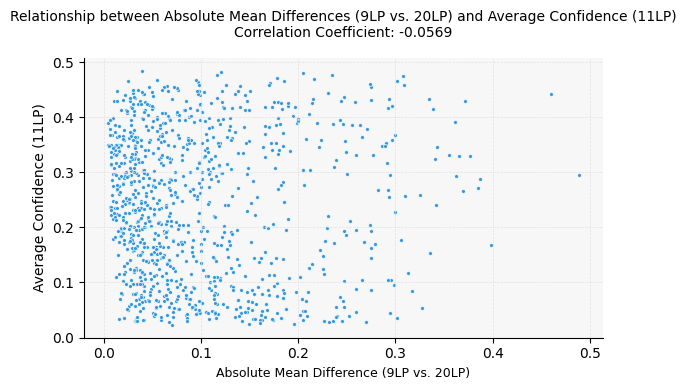

Model Type: LP, Comparison: 9LP vs. 20LP
    ID  abs_diff_9vs20  Average_Confidence
0    0        0.114591            0.041949
1    1        0.141775            0.045399
2    2        0.026532            0.244303
3    3        0.045223            0.214406
4    4        0.067092            0.221481
5    5        0.043931            0.263238
6    6        0.101512            0.408950
7    7        0.110732            0.426501
8    8        0.009418            0.248217
9    9        0.174950            0.093998
10  10        0.162735            0.031773
11  11        0.086598            0.192000
12  12        0.083985            0.395417
13  13        0.087651            0.060542
14  14        0.109246            0.300155
15  15        0.166308            0.418061
16  16        0.061896            0.188944
17  17        0.043889            0.297003
18  18        0.050027            0.150987
19  19        0.026743            0.140222
Unmatched IDs for LP, 9LP vs. 20LP: set()


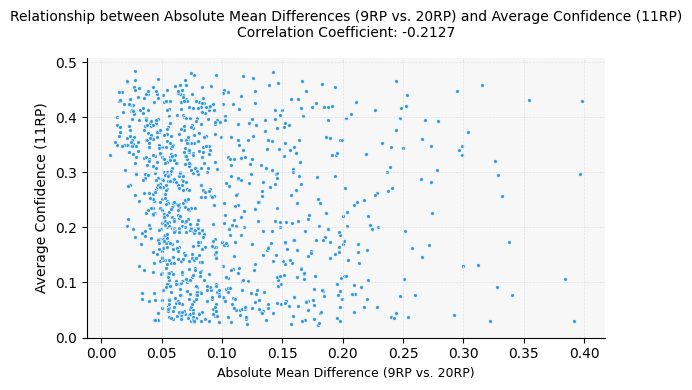

Model Type: RP, Comparison: 9RP vs. 20RP
    ID  abs_diff_9vs20  Average_Confidence
0    0        0.069571            0.041949
1    1        0.047219            0.045399
2    2        0.101759            0.244303
3    3        0.071578            0.214406
4    4        0.200508            0.221481
5    5        0.035223            0.263238
6    6        0.026953            0.408950
7    7        0.127500            0.426501
8    8        0.044024            0.248217
9    9        0.146580            0.093998
10  10        0.046626            0.031773
11  11        0.077968            0.192000
12  12        0.095744            0.395417
13  13        0.138342            0.060542
14  14        0.051952            0.300155
15  15        0.188128            0.418061
16  16        0.033325            0.188944
17  17        0.145027            0.297003
18  18        0.093798            0.150987
19  19        0.052585            0.140222
Unmatched IDs for RP, 9RP vs. 20RP: set()


In [11]:
# Parameters for correlation analysis
feature_numbers = ['9', '20']  
model_types = ['LP', 'RP']  
params = {
    'LP': {
        'comparison_labels': ['9LP vs. 20LP'],  
        'average_confidence_list': ['11'], 
        'average_confidence_labels': ['Average Confidence (11LP)'],
        'indices': ['9vs20']
    },
    'RP': {
        'comparison_labels': ['9RP vs. 20RP'], 
        'average_confidence_list': ['11'],  
        'average_confidence_labels': ['Average Confidence (11RP)'],
        'indices': ['9vs20']
    }
}

# correlation analysis for each model type
for model_type, model_params in params.items():
    comparison_labels = model_params['comparison_labels']
    average_confidence_list = model_params['average_confidence_list'] 
    average_confidence_labels = model_params['average_confidence_labels']
    indices = model_params['indices']

    for average_confidence, comparison_label, index, average_confidence_label in zip(
        average_confidence_list, comparison_labels, indices, average_confidence_labels
    ):
        merged_df_with_clusters = correlation_analysis(
            abs_diff_n=combined_mean_of_abs_diff[model_type],
            confidence_df=df_confidence[average_confidence][model_type],
            comparison_label=comparison_label,
            index=index,
            confidence_label=average_confidence_label, 
        )
# Debugging
        print(f"Model Type: {model_type}, Comparison: {comparison_label}")
        print(merged_df_with_clusters[['ID', 'abs_diff_9vs20', 'Average_Confidence']].head(20))

        # Find unmatched IDs
        unmatched_ids = set(combined_mean_of_abs_diff[model_type]['ID']) - set(df_confidence[average_confidence][model_type]['ID'])
        print(f"Unmatched IDs for {model_type}, {comparison_label}: {unmatched_ids}")

